In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from itertools import product
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
param_grid_dt = {
    'select__k': [5, 10, 15],
    'classifier__max_depth': [3, 5, None]
}

param_grid_knn = {
    'select__k': [5, 10, 15],
    'classifier__n_neighbors': [3, 5, 7]
}

param_grid_lr = {
    'select__k': [5, 10, 15],
    'classifier__C': [0.01, 0.1, 1, 10]
}


In [ ]:
# Manual Grid Search
def run_manual_grid_search(X, y, classifier, param_grid):
    best_score, best_params = -1, None
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    keys, values = zip(*param_grid.items())
    for v in product(*values):
        params = dict(zip(keys, v))
        scores = []
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('select', SelectKBest(score_func=f_classif, k=params['select__k'])),
                ('classifier', classifier.set_params(
                    **{k.split("__")[1]: params[k] for k in params if k != 'select__k'}))
            ])

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict_proba(X_val)[:,1]
            scores.append(roc_auc_score(y_val, y_pred))

        avg_score = np.mean(scores)
        if avg_score > best_score:
            best_score, best_params = avg_score, params

    return best_params, best_score


# GridSearchCV
def run_builtin_grid_search(X, y, classifier, param_grid):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif)),
        ('classifier', classifier)
    ])

    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    )
    grid.fit(X, y)

    return grid.best_params_, grid.best_score_, grid.best_estimator_


# Run all models
def run_all_models(X, y, dataset_name="Dataset"):
    results, best_models = [], {}

    # Decision Tree
    pm, sm = run_manual_grid_search(X, y, DecisionTreeClassifier(), param_grid_dt)
    pb, sb, mb = run_builtin_grid_search(X, y, DecisionTreeClassifier(), param_grid_dt)
    results += [[f"{dataset_name} - Decision Tree (Manual)", pm, round(sm,3)],
                [f"{dataset_name} - Decision Tree (GridCV)", pb, round(sb,3)]]
    best_models["Decision Tree"] = mb

    # kNN
    pm, sm = run_manual_grid_search(X, y, KNeighborsClassifier(), param_grid_knn)
    pb, sb, mb = run_builtin_grid_search(X, y, KNeighborsClassifier(), param_grid_knn)
    results += [[f"{dataset_name} - kNN (Manual)", pm, round(sm,3)],
                [f"{dataset_name} - kNN (GridCV)", pb, round(sb,3)]]
    best_models["kNN"] = mb

    # Logistic Regression
    pm, sm = run_manual_grid_search(X, y, LogisticRegression(max_iter=500), param_grid_lr)
    pb, sb, mb = run_builtin_grid_search(X, y, LogisticRegression(max_iter=500), param_grid_lr)
    results += [[f"{dataset_name} - Logistic Regression (Manual)", pm, round(sm,3)],
                [f"{dataset_name} - Logistic Regression (GridCV)", pb, round(sb,3)]]
    best_models["Logistic Regression"] = mb

    return pd.DataFrame(results, columns=["Model", "Best Params", "ROC AUC"]), best_models


# Plot results
def plot_results(best_models, X, y, dataset_name="Dataset"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                        test_size=0.2, random_state=42)

    for name, model in best_models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{dataset_name} - {name} - Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.3f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{dataset_name} - {name} - ROC Curve")
        plt.legend()
        plt.show()


HR Dataset Results:


,Model,Best Params,ROC AUC
0,HR Attrition - Decision Tree (Manual),"{'select__k': 15, 'classifier__max_depth': 3}",0.686
1,HR Attrition - Decision Tree (GridCV),"{'classifier__max_depth': 3, 'select__k': 15}",0.686
2,HR Attrition - kNN (Manual),"{'select__k': 10, 'classifier__n_neighbors': 7}",0.695
3,HR Attrition - kNN (GridCV),"{'classifier__n_neighbors': 7, 'select__k': 10}",0.695
4,HR Attrition - Logistic Regression (Manual),"{'select__k': 15, 'classifier__C': 0.1}",0.739
5,HR Attrition - Logistic Regression (GridCV),"{'classifier__C': 0.1, 'select__k': 15}",0.739


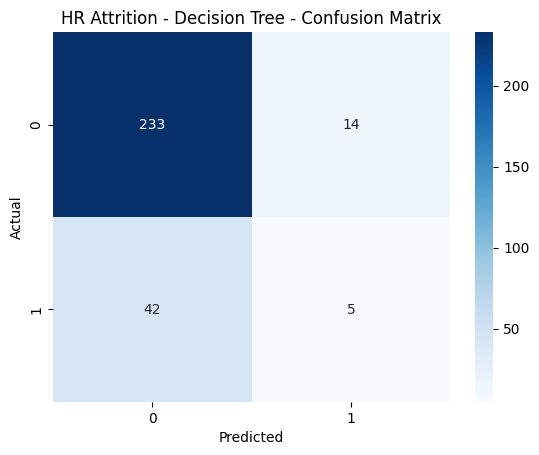

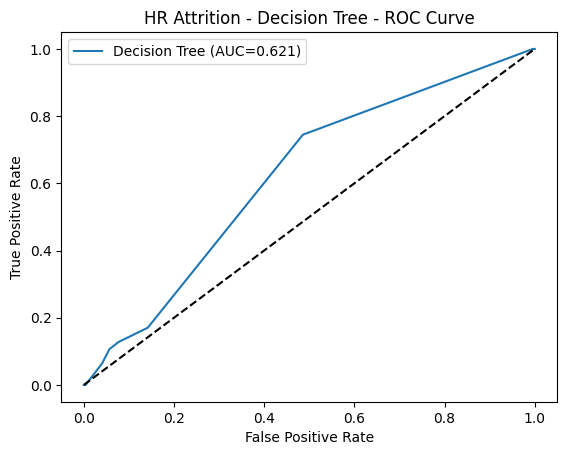

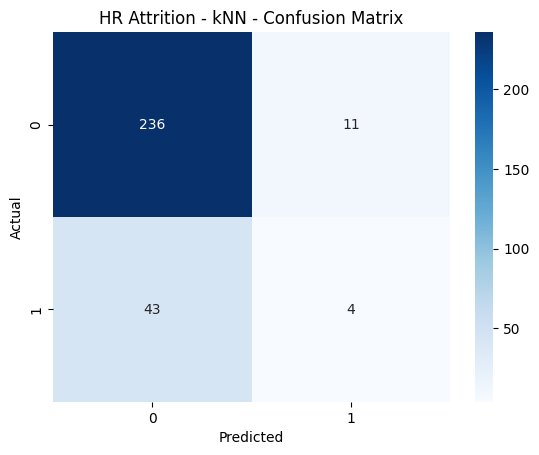

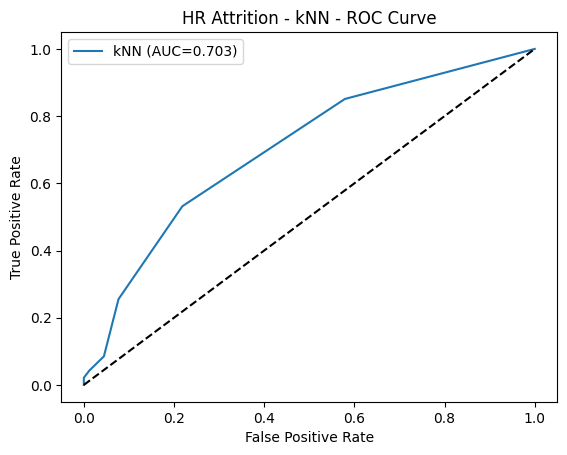

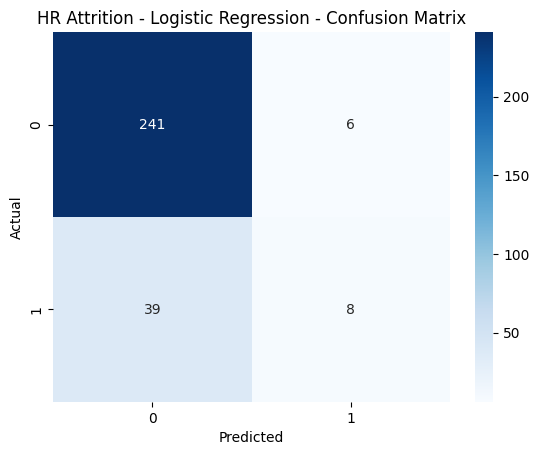

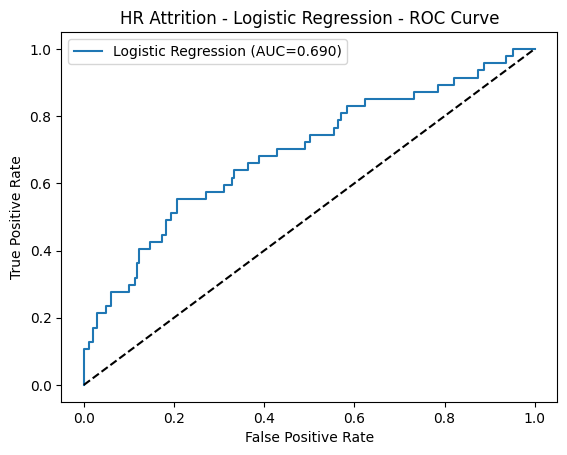

In [ ]:
# Upload WA_Fn-UseC_-HR-Employee-Attrition.csv manually via Colab sidebar before running
df_hr = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")

# Drop constant features
df_hr = df_hr.loc[:, df_hr.nunique() > 1]

# Features & labels
X_hr = df_hr.drop("Attrition", axis=1)._get_numeric_data().values
y_hr = (df_hr["Attrition"] == "Yes").astype(int).values

# Run
results_hr, best_hr = run_all_models(X_hr, y_hr, "HR Attrition")
print("HR Dataset Results:")
display(results_hr)

# Plots
plot_results(best_hr, X_hr, y_hr, "HR Attrition")


Wine Dataset Results:


,Model,Best Params,ROC AUC
0,Wine Quality - Decision Tree (Manual),"{'select__k': 10, 'classifier__max_depth': 5}",0.784
1,Wine Quality - Decision Tree (GridCV),"{'classifier__max_depth': 5, 'select__k': 5}",0.784
2,Wine Quality - kNN (Manual),"{'select__k': 5, 'classifier__n_neighbors': 5}",0.809
3,Wine Quality - kNN (GridCV),"{'classifier__n_neighbors': 5, 'select__k': 5}",0.809
4,Wine Quality - Logistic Regression (Manual),"{'select__k': 10, 'classifier__C': 10}",0.817
5,Wine Quality - Logistic Regression (GridCV),"{'classifier__C': 10, 'select__k': 10}",0.817


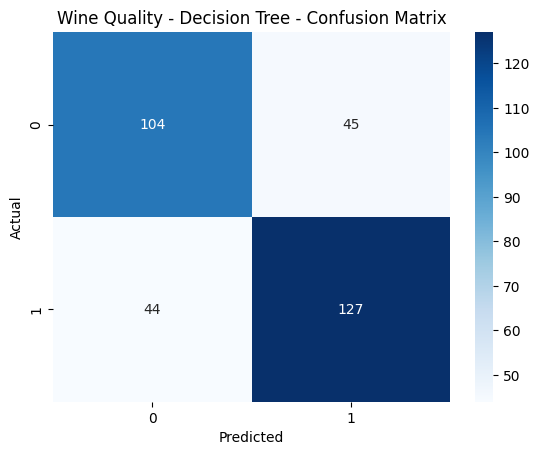

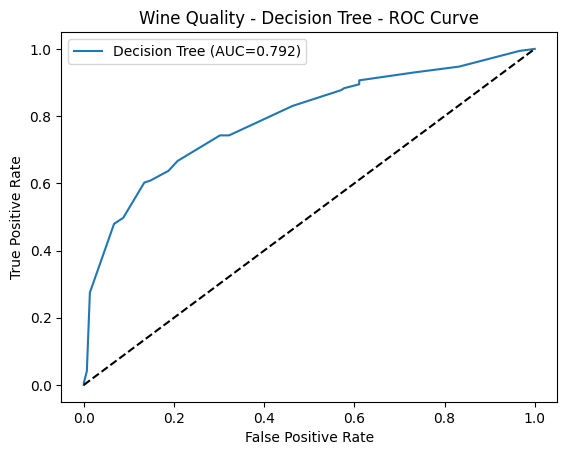

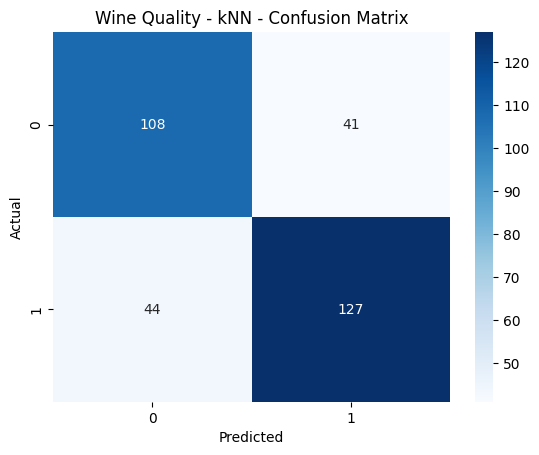

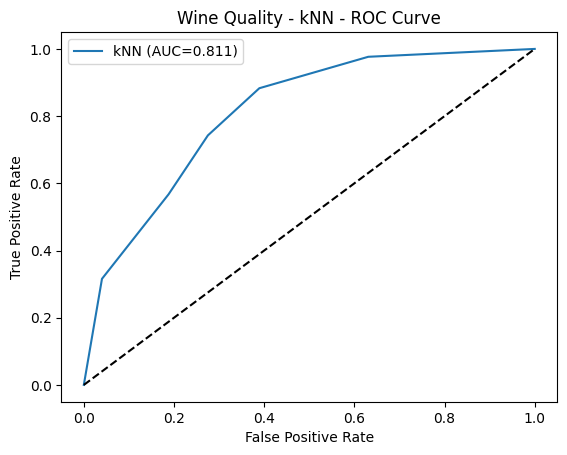

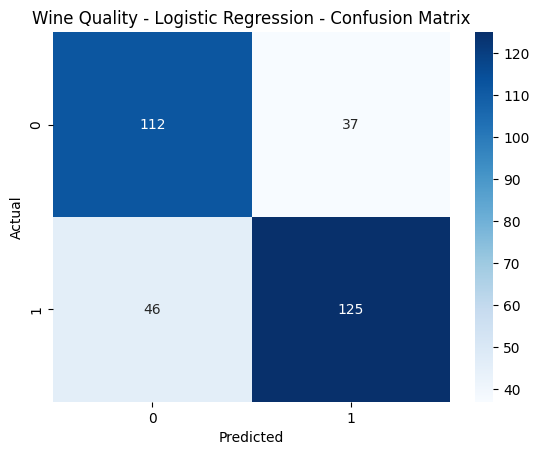

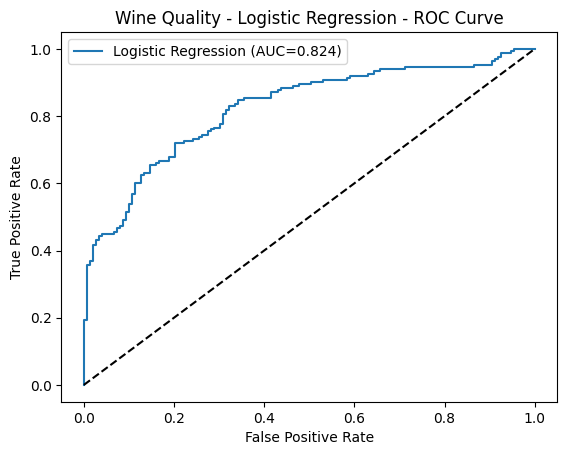

In [ ]:
# Download wine dataset
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

df_wine = pd.read_csv("winequality-red.csv", sep=";")

# Target: quality >= 6 -> 1 (good), else 0 (bad)
df_wine["target"] = (df_wine["quality"] >= 6).astype(int)

X_wine = df_wine.drop(["quality", "target"], axis=1).values
y_wine = df_wine["target"].values

# Run
results_wine, best_wine = run_all_models(X_wine, y_wine, "Wine Quality")
print("Wine Dataset Results:")
display(results_wine)

# Plots
plot_results(best_wine, X_wine, y_wine, "Wine Quality")
